**Sumber Dataset : https://www.kaggle.com/uciml/pima-indians-diabetes-database**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/spark-3.0.1-bin-hadoop2.7.tgz"

In [ ]:
import findspark
findspark.init("spark-3.0.1-bin-hadoop2.7")
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [ ]:
from __future__ import print_function

import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline

print (pyspark.__version__)

3.0.1


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd //content/drive/MyDrive/Dataset

[Errno 2] No such file or directory: '//content/drive/MyDrive/Dataset'
/content


In [ ]:
!ls

In [ ]:
from pyspark.ml.clustering import KMeans

dataset = spark.read.csv("diabetes.csv",header=True,inferSchema=True)

In [ ]:
dataset.head()

Row(Pregnancies=6, Glucose=148, BloodPressure=72, SkinThickness=35, Insulin=0, BMI=33.6, DiabetesPedigreeFunction=0.627, Age=50, Outcome=1)

In [ ]:
#FORMAT DATA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
dataset = dataset.na.drop()
dataset.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [ ]:
#FORMAT DATA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
dataset.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [ ]:
dataset = dataset.na.drop()
dataset.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [ ]:
vec_assembler = VectorAssembler(inputCols = dataset.columns, outputCol='features')

In [ ]:
final_data = vec_assembler.transform(dataset).select('Glucose', 'features')
final_data.show()

+-------+--------------------+
|Glucose|            features|
+-------+--------------------+
|    148|[6.0,148.0,72.0,3...|
|     85|[1.0,85.0,66.0,29...|
|    183|[8.0,183.0,64.0,0...|
|     89|[1.0,89.0,66.0,23...|
|    137|[0.0,137.0,40.0,3...|
|    116|[5.0,116.0,74.0,0...|
|     78|[3.0,78.0,50.0,32...|
|    115|[10.0,115.0,0.0,0...|
|    197|[2.0,197.0,70.0,4...|
|    125|[8.0,125.0,96.0,0...|
|    110|[4.0,110.0,92.0,0...|
|    168|[10.0,168.0,74.0,...|
|    139|[10.0,139.0,80.0,...|
|    189|[1.0,189.0,60.0,2...|
|    166|[5.0,166.0,72.0,1...|
|    100|[7.0,100.0,0.0,0....|
|    118|[0.0,118.0,84.0,4...|
|    107|[7.0,107.0,74.0,0...|
|    103|[1.0,103.0,30.0,3...|
|    115|[1.0,115.0,70.0,3...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import StandardScaler

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [ ]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [ ]:
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

In [ ]:
# Training a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)

In [ ]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[2.11518255 4.02972657 3.88114671 0.75367122 0.20060204 4.04608718
 1.29464994 3.85467055 1.09597602]
[0.6502593  3.25630403 3.24969778 1.20828775 0.48631166 3.75522631
 1.23081337 2.21885434 0.15368114]
[0.97970866 4.65967244 3.89596972 2.17668117 1.81861384 4.7697434
 2.0408888  2.86241393 1.57880254]


In [ ]:
model.transform(final_data).select('Glucose' , 'prediction').show()

+-------+----------+
|Glucose|prediction|
+-------+----------+
|    148|         0|
|     85|         1|
|    183|         0|
|     89|         1|
|    137|         2|
|    116|         1|
|     78|         1|
|    115|         1|
|    197|         2|
|    125|         0|
|    110|         1|
|    168|         0|
|    139|         0|
|    189|         2|
|    166|         0|
|    100|         1|
|    118|         2|
|    107|         0|
|    103|         1|
|    115|         2|
+-------+----------+
only showing top 20 rows



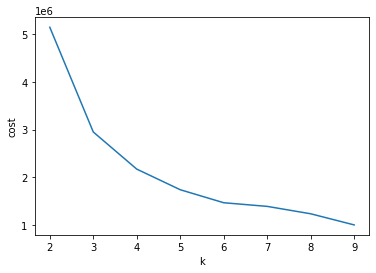

In [ ]:
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(final_data)
    cost[k] = model.summary.trainingCost

# Plot the cost
dataset_cost = pd.DataFrame(cost[2:])
dataset_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
dataset_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(dataset_cost.cluster, dataset_cost.cost)
pl.xlabel('k')
pl.ylabel('cost')
pl.show()